## XGBoost on Lending Club Dataset

In this dataset, we train an XGBoost binary classifier on the Lending Club dataset.

In [40]:
import xgboost
import shap
import numpy as np
import pandas as pd
import onnxruntime as rt
import onnxmltools

from onnxmltools import convert_xgboost, convert_sklearn
from onnxmltools.convert.common.data_types import FloatTensorType
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
from json import load, dump

SEED=2022

print(onnxmltools.__version__)

1.11.2


In [2]:
# Read the dataset
data = pd.read_csv('../data/lending-club.csv')
data['earliest_cr_line'] = 2023 - data['earliest_cr_line']

y_all = data['loan_approval']
x_all = data.iloc[:, 0: data.shape[1] - 1]

# One-hot encode the categorical columns
x_all = pd.get_dummies(x_all, prefix_sep='-')

# Train test split (6:4)
x_train, x_test, y_train, y_test = train_test_split(
    x_all, y_all, test_size=0.4, random_state=SEED
)

# Convert data frames to numpy arrays
feature_names = x_all.columns
x_train_matrix = x_train.to_numpy()
x_test_matrix = x_test.to_numpy()
y_train_array = y_train.to_numpy()
y_test_array = y_test.to_numpy()

# Create lightgbm dataset
d_train = xgboost.DMatrix(x_train, label=y_train)
d_test = xgboost.DMatrix(x_test, label=y_test)


In [3]:
params = {
    "eta": 0.01,
    "objective": "binary:logistic",
    # Randomly sample training data in each boosting iteration to avoid overfitting
    "subsample": 0.5,
    # Initial prediction: average of the training labels
    "eval_metric": "logloss",
}

model = xgboost.train(
    params,
    d_train,
    5000,
    evals=[(d_test, "test")],
    verbose_eval=100,
    early_stopping_rounds=20,
)

[0]	test-logloss:0.68927
[100]	test-logloss:0.50881
[200]	test-logloss:0.47502
[300]	test-logloss:0.47003
[325]	test-logloss:0.47043


In [4]:
y_pred = model.predict(d_train)
y_pred_label = [1 if y >= 0.5 else 0 for y in y_pred]
train_acc = accuracy_score(y_train, y_pred_label)

y_pred = model.predict(d_test)
y_pred_label = [1 if y >= 0.5 else 0 for y in y_pred]
test_acc = accuracy_score(y_test, y_pred_label)

print(f'Train accuracy: {train_acc:.4}, Test accuracy: {test_acc:.4}')

Train accuracy: 0.848, Test accuracy: 0.7955


### Export the Model as ONNX

To use this model in Rust and the web, we export it as an ONNX model.

In [5]:
temp_model = model.copy()

# Need to convert real feature names to f0, f1, f2... for ONNX
feature_name_map = {}
new_feature_names = []
for i in range(len(temp_model.feature_names)):
    feature_name_map[f'f{i}'] = temp_model.feature_names[i]
    new_feature_names.append(f'f{i}')

temp_model.feature_names = new_feature_names

In [6]:
initial_types = [("float_input", FloatTensorType([None, x_train.shape[1]]))]
model_onnx = convert_xgboost(temp_model, initial_types=initial_types)

In [8]:
# # Save the ONNX model
# with open('./lending-club-xgboost.onnx', 'wb') as fp:
#     fp.write(model_onnx.SerializeToString())

### ONNX Model Inference

Model inference using the saved ONNX model.


In [9]:
session = rt.InferenceSession('./lending-club-xgboost.onnx')
y_pred_onnx = session.run(None, {'float_input': x_test.astype(np.float32).to_numpy()})

In [10]:
test_acc = accuracy_score(y_test, y_pred_onnx[0])
print(f'ONNX Test accuracy: {test_acc:.4}')

ONNX Test accuracy: 0.796


In [24]:
# cur_x = np.array([[

#   22,
#   43.4,
#   9.32,
#   4.7542030368453085,
#   8,
#   24000,
#   17,
#   4.249296215544277,
#   697,
#   0,
#   1,
#   0,
#   0,
#   0,
#   0,
#   0,
#   1,
#   0,
#   0,
#   1,
#   1,
#   0,
#   0,
#   0,
#   1,
#   0,
#   1,
#   0,
#   0,
#   0,
#   0

# ]])

# session = rt.InferenceSession('./lending-club-xgboost.onnx')
# session.run(None, {'float_input': cur_x.astype(np.float32)})

### Export to JSON Data

In [11]:
rng = np.random.RandomState(SEED)
random_indexes = rng.choice(x_train_matrix.shape[0], 300)
random_x_train = x_train_matrix[random_indexes].astype(float).round(4).tolist()
random_y_train = y_train_array[random_indexes].astype(float).round(4).tolist()


In [31]:
# For test data, we sample half positive and half negative
pos_indexes = np.where(y_pred >= 0.5)[0]
neg_indexes = np.where(y_pred < 0.5)[0]

random_indexes_pos = pos_indexes[rng.choice(pos_indexes.shape[0], 150)]
random_indexes_neg = neg_indexes[rng.choice(neg_indexes.shape[0], 150)]
random_indexes = np.hstack([random_indexes_pos, random_indexes_neg])

random_x_test = x_test_matrix[random_indexes].astype(float).round(4).tolist()
random_y_test = y_test_array[random_indexes].astype(float).round(4).tolist()

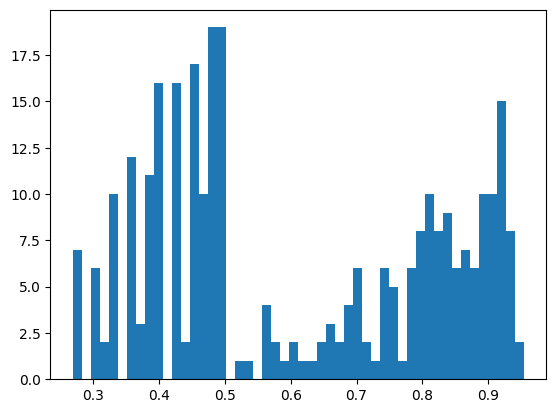

In [42]:
cur_x_mat = xgboost.DMatrix(random_x_test, feature_names=feature_names)
cur_pred = model.predict(cur_x_mat)
plt.hist(cur_pred, bins=50)
plt.show()

In [43]:
# Users can provide a partial dictionary to add descriptions for some features/levels
feature_info = {
    "loan_amnt": ["Loan Amount", "Amount of applied loan ($)"],
    "term": ["Payment Period", "The period of time to pay off the loan (month)"],
    "emp_length": ["Employment Length", "Length of your current employment (years)"],
    "home_ownership": ["Home Ownership", "Current home ownership status"],
    "annual_inc": ["Annual Income", "Annual income ($)"],
    "verification_status": ["Verification Status", "Status of income verification"],
    "purpose": ["Loan Purpose", "Purpose for the applied loan"],
    "dti": [
        "Debt to Income Ratio",
        "Monthly debt payments divided by the gross monthly income (%)",
    ],
    "delinq_2yrs": [
        "Number of Past Due",
        "The number of times of 30+ days past due on a payment in the past 2 years",
    ],
    "earliest_cr_line": ["Credit History Length", "Years of credit history"],
    "inq_last_6mths": [
        "Number of Credit Inquiries",
        "Number of credit inquiries in the last 6 months",
    ],
    "open_acc": [
        "Number of Open Accounts",
        "The number of open credit lines currently in the credit file",
    ],
    "pub_rec": [
        "Number of Derogatory Records",
        "Number of derogatory public records (e.g., crime records)",
    ],
    "revol_bal": [
        "Revolving Balance",
        "The unpaid balance amount, if the balance on revolving credit account is not paid in full ($)",
    ],
    "revol_util": [
        "Credit Utilization",
        "The amount of credit used relative to all available revolving credit (%)",
    ],
    "total_acc": [
        "Number of Accounts",
        "The total number of credit lines currently in the credit file",
    ],
    "application_type": [
        "Application Type",
        "Whether the loan is an individual application or a joint application with two co-borrowers",
    ],
    "mort_acc": ["Number of Mortgages", "Number of mortgage accounts"],
    "pub_rec_bankruptcies": [
        "Number of Bankruptcies",
        "Number of public record bankruptcies",
    ],
    "fico_score": ["FICO Score", "Current FICO score (credit score)"],
}

feature_level_info = {
    "term": {
        "36 months": ["36 months", ""],
        "60 months": ["60 months", ""],
    },
    "home_ownership": {
        "MORTGAGE": ["Mortgage", ""],
        "OTHER": ["Other", ""],
        "OWN": ["Own", ""],
        "RENT": ["Rent", ""],
    },
    "application_type": {
        "Individual": ["Individual Application", ""],
        "Joint App": ["Joint Applciation", ""],
    },
    "verification_status": {
        "Not Verified": ["Not Verified", ""],
        "Source Verified": ["Source Verified", ""],
        "Verified": ["Verified", ""],
    },
    "pub_rec": {
        "0": ["0 time", ""],
        "1": ["1 time", ""],
        "2": ["2 times", ""],
        "2+": ["More than 2 times", ""],
    },
    "pub_rec_bankruptcies": {
        "0": ["0 time", ""],
        "1": ["1 time", ""],
        "2": ["2 times", ""],
        "2+": ["More than 2 times", ""],
        "missing": ["Missing", ""],
    },
}

require_transform = ["annual_inc", "revol_bal"]
require_integer = [
    "loan_amnt",
    "annual_inc",
    "revol_bal" "delinq_2yrs",
    "earliest_cr_line",
    "inq_last_6mths",
    "open_acc",
    "pub_rec",
    "total_acc",
    "mort_acc",
    "pub_rec_bankruptcies",
    "fico_score",
]


In [44]:
feature_types = []
for name in feature_names:
    if '-' in name:
        feature_types.append('cat')
    else:
        feature_types.append('cont')

json_data = {
    'xTrain': random_x_train,
    'yTrain': random_y_train,
    'xTest': random_x_test,
    'yTest': random_y_test,
    'featureNames': feature_names.tolist(),
    'featureTypes': feature_types,
    'featureInfo': feature_info,
    'featureLevelInfo': feature_level_info,
    'featureRequiresLog': require_transform,
    'featureRequireInt': require_integer
}


In [45]:
dump(json_data, open('../demo/public/data/lending-club.json', 'w'))